# Random Forest Examples

+ Using synthetic data and the Iris dataset.

### Packages

In [1]:
%matplotlib inline
# data and plotting packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# modeling packages
import scipy.stats as stats
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.datasets import load_iris

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier

from mlutils import plot_classes, plot_decision_boundary

### Display Settings

In [2]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['legend.fontsize'] = 'x-large'
plt.rcParams['axes.labelsize'] = 'x-large'
plt.rcParams['axes.titlesize'] = 'x-large'
plt.rcParams['xtick.labelsize'] = 'x-large'
plt.rcParams['ytick.labelsize'] = 'x-large'

### Data Generation

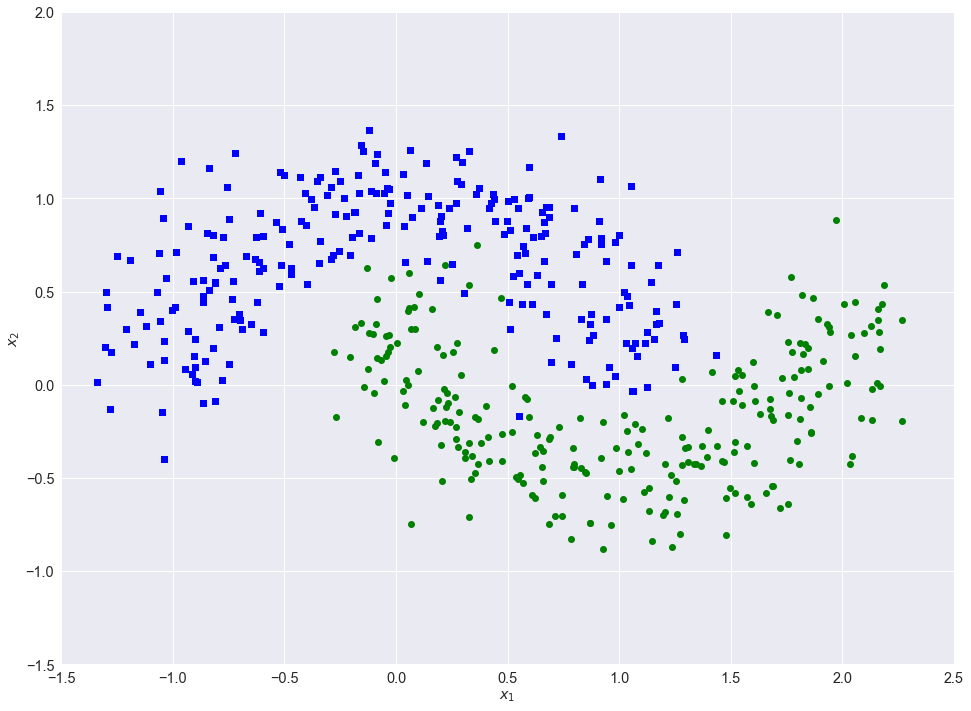

In [3]:
rnd_state = 123
X, y = make_moons(n_samples=500, noise=0.20, random_state=rnd_state)

axlim = [-1.5, 2.5, -1.5, 2.0]

# plot the generated 2D data
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

plot_classes(X, y, ax, axlim)
ax.set(xlabel=r"$x_1$", ylabel= r"$x_2$")

# split into train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Voting Classification

We fit a four classification models and two voting classifiers, with hard and soft voting.

In [4]:
log_clf = LogisticRegression(solver="liblinear", random_state=rnd_state)
svm_clf = SVC(gamma="auto", probability=True, random_state=rnd_state)
bag_clf = BaggingClassifier(n_estimators=10, random_state=rnd_state)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=rnd_state)

hvot_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('svc', svm_clf), ('bag', bag_clf), ('rf', rnd_clf)], 
    voting='hard')

svot_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('svc', svm_clf), ('bag', bag_clf), ('rf', rnd_clf)], 
    voting='soft')

# compute out-of-sample accuracy for all models
print('Model                    Accuracy')
print('---------------------------------')
for clf in (log_clf, svm_clf, bag_clf, rnd_clf, hvot_clf, svot_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('{0:24s} {1}'.format(clf.__class__.__name__, accuracy_score(y_test, y_pred)))


Model                    Accuracy
---------------------------------
LogisticRegression       0.888
SVC                      0.976
BaggingClassifier        0.968
RandomForestClassifier   0.976
VotingClassifier         0.992
VotingClassifier         0.976


### Bagging Classification

We fit a decision tree classifier and use it to do bagging.

In [5]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=rnd_state), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, oob_score=True, random_state=rnd_state)
bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)

# compute out-of-sample accuracy for all models
print('Model                    Accuracy')
print('---------------------------------')
print('{0:24s} {1}'.format('DecisionTree', accuracy_score(y_test, y_pred_tree)))
print('{0:24s} {1}'.format('BaggingClassifier', accuracy_score(y_test, y_pred_bag)))
print('\nBaggingClassifier OOB score:', np.round(bag_clf.oob_score_, 4))


Model                    Accuracy
---------------------------------
DecisionTree             0.96
BaggingClassifier        0.968

BaggingClassifier OOB score: 0.96


#### Decision Boundaries

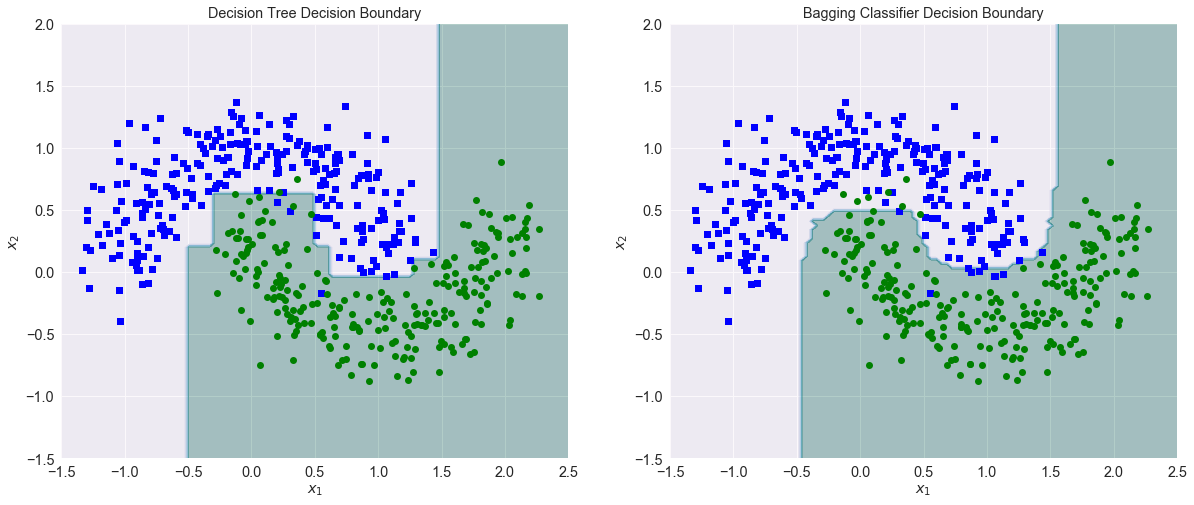

In [6]:
# plot decision boundaries for the tree and the bag
# Display results
fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

plot_decision_boundary(tree_clf, ax1, axlim)
plot_decision_boundary(bag_clf, ax2, axlim)
# plot the observations
ax1.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
ax1.plot(X[:, 0][y==1], X[:, 1][y==1], "go")
ax1.set(xlabel='$x_1$', ylabel='$x_2$', title='Decision Tree Decision Boundary')

ax2.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
ax2.plot(X[:, 0][y==1], X[:, 1][y==1], "go")
ax2.set(xlabel='$x_1$', ylabel='$x_2$', title='Bagging Classifier Decision Boundary');


## Random Forest  
Using the Iris dataset.

In [7]:
# load the iris dataset from sklearn; note sklearn does not use pandas dataframes
iris = load_iris()
# anatomy of the data object
print("feature_names: {}".format(iris.feature_names))
print("feature_shape: {}".format(iris.data.shape))
print("target_names: {}".format(iris.target_names))
print("target_shape: {}".format(iris.target.shape))

feature_names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
feature_shape: (150, 4)
target_names: ['setosa' 'versicolor' 'virginica']
target_shape: (150,)


We fit a random forest using all features

In [8]:
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=rnd_state)
rnd_clf.fit(iris["data"], iris["target"])

print('Feature              Relevance Score')
print('------------------------------------')
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print('{0:20s} {1:4.3f}'.format(name, score))

Feature              Relevance Score
------------------------------------
sepal length (cm)    0.094
sepal width (cm)     0.024
petal length (cm)    0.459
petal width (cm)     0.423


#### Decision Boundary
We fit a random forest on the two most relevant features and plot the boundary

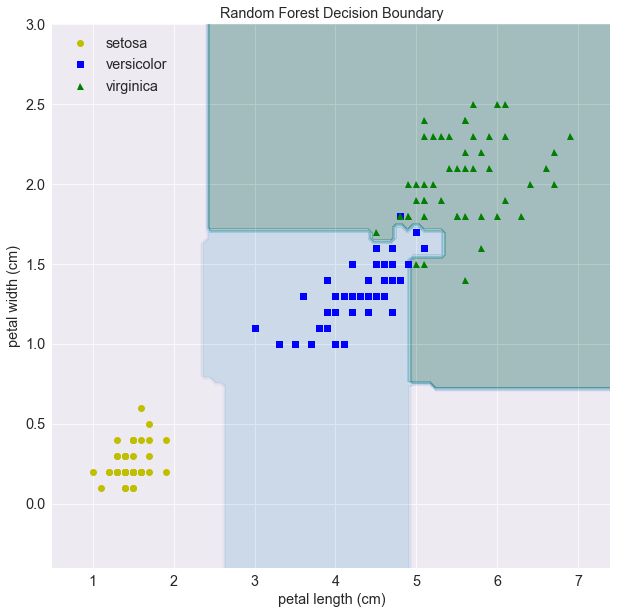

In [9]:
# axes limits for plotting
feat0_idx = 2
feat1_idx = 3
X = iris.data[:, (feat0_idx, feat1_idx)]                    # choose the features here
y = iris.target                       

xlim = [min(X[:, 0]) - 0.5, max(X[:, 0]) + 0.5]
ylim = [min(X[:, 1]) - 0.5, max(X[:, 1]) + 0.5]
axlim = xlim + ylim

rnd_2f_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=rnd_state)
rnd_2f_clf.fit(X, y)

# create a plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
plot_decision_boundary(rnd_2f_clf, ax, axlim)
# plot the observations
ax.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label=iris.target_names[0])
ax.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label=iris.target_names[1])
ax.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label=iris.target_names[2])
ax.set(xlabel=iris.feature_names[feat0_idx], ylabel=iris.feature_names[feat1_idx])
ax.set(title='Random Forest Decision Boundary')
ax.legend(loc='upper left');